In [24]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px
from kmeans_pytorch import kmeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [25]:
data_dir = 'dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

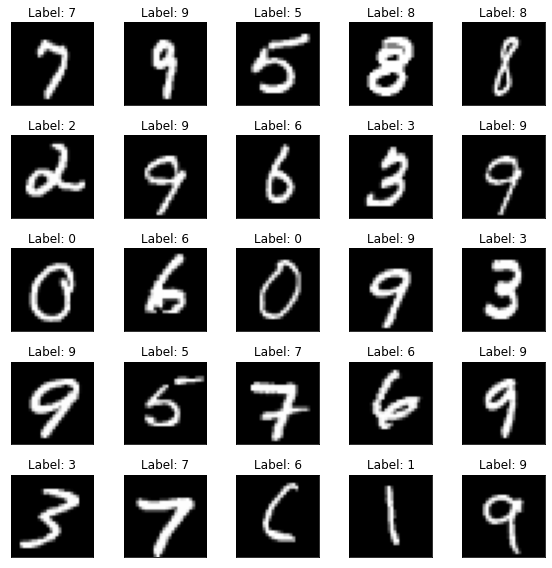

In [26]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [27]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [28]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [29]:
print("training:%d"%len(train_data))
print("Validation:%d"%len(val_data))
print("testing:%d"%len(test_dataset))

training:48000
Validation:12000
testing:10000


In [42]:
With_Random_Noise = False

# Step 1: Define Encoder and Decoder classes

In [43]:
class Encoder_cnn(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [44]:
class Decoder_cnn(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# Step 2: initialize models, loss and optimizer

In [45]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks 
d = 2 
#d = 16
#d = 256

encoder = Encoder_cnn(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder_cnn(encoded_space_dim=d,fc2_input_dim=128)

In [46]:
### Define the loss function
#loss_fn = torch.nn.MSELoss()
loss_fn=torch.nn.L1Loss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cpu


Decoder_cnn(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Step 3 :Train model

In [47]:
#pip install opencv-python

In [48]:
im = test_dataset[0][0].unsqueeze(0)
a = im + torch.randn_like(im)*0.3
print(a)

tensor([[[[-4.8035e-01, -2.3065e-01,  4.0235e-01,  2.9175e-01,  2.6696e-01,
            1.5245e-02,  8.4976e-02, -1.0898e-01, -3.2899e-01,  9.9044e-02,
            5.1507e-01,  5.2921e-01,  2.3706e-01, -2.3308e-02, -5.0176e-01,
            1.1964e-02, -4.1276e-01, -9.7505e-02,  4.7835e-03, -4.5502e-01,
           -8.3892e-02, -1.4274e-01, -3.8900e-01,  4.9235e-02, -8.8219e-02,
            5.9765e-01, -2.3499e-01, -6.3434e-01],
          [-5.0670e-01, -1.2626e-01, -1.9843e-01, -4.1258e-01,  2.6870e-01,
           -4.1443e-01,  3.5244e-01, -9.8254e-02, -1.7854e-01, -2.9345e-01,
            5.0249e-01,  1.9235e-01, -9.3370e-02, -2.5076e-01, -2.0044e-01,
            2.3191e-01,  1.3019e-01, -3.5066e-01,  2.3686e-01,  1.8410e-02,
           -7.8928e-01, -2.4858e-01, -1.1199e-01,  1.9037e-04,  4.0482e-01,
            4.7119e-01, -2.4263e-01,  1.6480e-01],
          [ 3.3293e-01, -3.1239e-01, -6.2113e-01,  6.7252e-01, -7.0149e-02,
            3.4890e-02, -5.8114e-02, -5.8682e-03,  2.5180e-01,

In [49]:
im = test_dataset[0][0].unsqueeze(0)

In [50]:
im

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [51]:
b = torch.clip(a,0.,1.)
print(b)

tensor([[[[0.0000e+00, 0.0000e+00, 4.0235e-01, 2.9175e-01, 2.6696e-01,
           1.5245e-02, 8.4976e-02, 0.0000e+00, 0.0000e+00, 9.9044e-02,
           5.1507e-01, 5.2921e-01, 2.3706e-01, 0.0000e+00, 0.0000e+00,
           1.1964e-02, 0.0000e+00, 0.0000e+00, 4.7835e-03, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9235e-02, 0.0000e+00,
           5.9765e-01, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6870e-01,
           0.0000e+00, 3.5244e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           5.0249e-01, 1.9235e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           2.3191e-01, 1.3019e-01, 0.0000e+00, 2.3686e-01, 1.8410e-02,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9037e-04, 4.0482e-01,
           4.7119e-01, 0.0000e+00, 1.6480e-01],
          [3.3293e-01, 0.0000e+00, 0.0000e+00, 6.7252e-01, 0.0000e+00,
           3.4890e-02, 0.0000e+00, 0.0000e+00, 2.5180e-01, 3.8944e-01,
           0.0000e+00, 3.1756e-01, 3.6842e-01, 1.727

In [66]:
def add_noise(inputs,noise_factor=0.3):
     noise = inputs+torch.randn_like(inputs)*noise_factor
     noise = torch.clip(noise,0.,1.)
     return noise

In [71]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        if With_Random_Noise:
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)    
        # Encode data
            encoded_data = encoder(image_noisy)
        else:
            encoded_data = encoder(image_batch)
        
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        #loss = loss_fn(decoded_data, image_noisy)
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [72]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            if With_Random_Noise:
                image_noisy = add_noise(image_batch,noise_factor)
                image_noisy = image_noisy.to(device)
                # Encode data
                encoded_data = encoder(image_noisy)
            else:
                encoded_data = encoder(image_batch)
                
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [73]:
def plot_ae_outputs_den(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[i][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()

EPOCH 1/30
	 partial train loss (single batch): 0.127631
	 partial train loss (single batch): 0.125279
	 partial train loss (single batch): 0.127472
	 partial train loss (single batch): 0.127289
	 partial train loss (single batch): 0.127576
	 partial train loss (single batch): 0.125222
	 partial train loss (single batch): 0.128448
	 partial train loss (single batch): 0.125252
	 partial train loss (single batch): 0.126439
	 partial train loss (single batch): 0.124536
	 partial train loss (single batch): 0.126688
	 partial train loss (single batch): 0.121642
	 partial train loss (single batch): 0.127337
	 partial train loss (single batch): 0.122502
	 partial train loss (single batch): 0.124052
	 partial train loss (single batch): 0.124722
	 partial train loss (single batch): 0.123359
	 partial train loss (single batch): 0.125283
	 partial train loss (single batch): 0.123391
	 partial train loss (single batch): 0.121269
	 partial train loss (single batch): 0.120862
	 partial train loss (s

	 partial train loss (single batch): 0.097469
	 partial train loss (single batch): 0.097406
	 partial train loss (single batch): 0.098474
	 partial train loss (single batch): 0.099308
	 partial train loss (single batch): 0.101273
	 partial train loss (single batch): 0.091788
	 partial train loss (single batch): 0.099602
	 partial train loss (single batch): 0.097670

 EPOCH 1/30 	 train loss 0.111 	 val loss 0.100


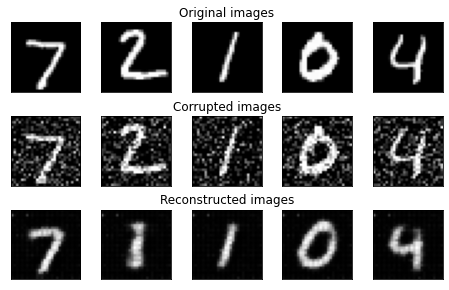

EPOCH 2/30
	 partial train loss (single batch): 0.099330
	 partial train loss (single batch): 0.097605
	 partial train loss (single batch): 0.099663
	 partial train loss (single batch): 0.098867
	 partial train loss (single batch): 0.099298
	 partial train loss (single batch): 0.098534
	 partial train loss (single batch): 0.101084
	 partial train loss (single batch): 0.097396
	 partial train loss (single batch): 0.099863
	 partial train loss (single batch): 0.097327
	 partial train loss (single batch): 0.100502
	 partial train loss (single batch): 0.094706
	 partial train loss (single batch): 0.100873
	 partial train loss (single batch): 0.094883
	 partial train loss (single batch): 0.098093
	 partial train loss (single batch): 0.098085
	 partial train loss (single batch): 0.098415
	 partial train loss (single batch): 0.100257
	 partial train loss (single batch): 0.099736
	 partial train loss (single batch): 0.097008
	 partial train loss (single batch): 0.095327
	 partial train loss (s

	 partial train loss (single batch): 0.088045
	 partial train loss (single batch): 0.087258
	 partial train loss (single batch): 0.089520
	 partial train loss (single batch): 0.090471
	 partial train loss (single batch): 0.091808
	 partial train loss (single batch): 0.082634
	 partial train loss (single batch): 0.089826
	 partial train loss (single batch): 0.088168

 EPOCH 2/30 	 train loss 0.094 	 val loss 0.091


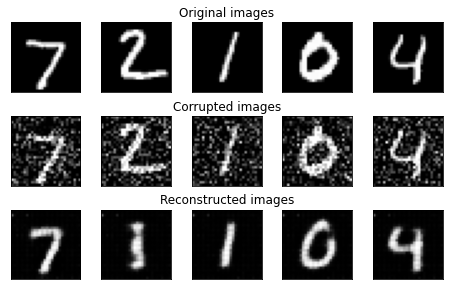

EPOCH 3/30
	 partial train loss (single batch): 0.090598
	 partial train loss (single batch): 0.088565
	 partial train loss (single batch): 0.090330
	 partial train loss (single batch): 0.089924
	 partial train loss (single batch): 0.089802
	 partial train loss (single batch): 0.090073
	 partial train loss (single batch): 0.092541
	 partial train loss (single batch): 0.088129
	 partial train loss (single batch): 0.092048
	 partial train loss (single batch): 0.088171
	 partial train loss (single batch): 0.091938
	 partial train loss (single batch): 0.085991
	 partial train loss (single batch): 0.093079
	 partial train loss (single batch): 0.086330
	 partial train loss (single batch): 0.089233
	 partial train loss (single batch): 0.089021
	 partial train loss (single batch): 0.089599
	 partial train loss (single batch): 0.091866
	 partial train loss (single batch): 0.091755
	 partial train loss (single batch): 0.087937
	 partial train loss (single batch): 0.087177
	 partial train loss (s

	 partial train loss (single batch): 0.089018
	 partial train loss (single batch): 0.090270
	 partial train loss (single batch): 0.083439
	 partial train loss (single batch): 0.082574
	 partial train loss (single batch): 0.085273
	 partial train loss (single batch): 0.086409
	 partial train loss (single batch): 0.087254
	 partial train loss (single batch): 0.078426
	 partial train loss (single batch): 0.085290
	 partial train loss (single batch): 0.083581

 EPOCH 3/30 	 train loss 0.087 	 val loss 0.086


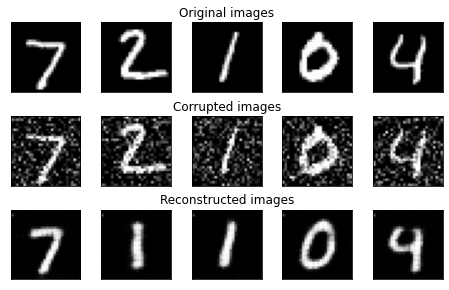

EPOCH 4/30
	 partial train loss (single batch): 0.085866
	 partial train loss (single batch): 0.083995
	 partial train loss (single batch): 0.085646
	 partial train loss (single batch): 0.086195
	 partial train loss (single batch): 0.085828
	 partial train loss (single batch): 0.085888
	 partial train loss (single batch): 0.088700
	 partial train loss (single batch): 0.083754
	 partial train loss (single batch): 0.088090
	 partial train loss (single batch): 0.084049
	 partial train loss (single batch): 0.087760
	 partial train loss (single batch): 0.081849
	 partial train loss (single batch): 0.089226
	 partial train loss (single batch): 0.082399
	 partial train loss (single batch): 0.085267
	 partial train loss (single batch): 0.084854
	 partial train loss (single batch): 0.085921
	 partial train loss (single batch): 0.087397
	 partial train loss (single batch): 0.088013
	 partial train loss (single batch): 0.083201
	 partial train loss (single batch): 0.082552
	 partial train loss (s

	 partial train loss (single batch): 0.087234
	 partial train loss (single batch): 0.080852
	 partial train loss (single batch): 0.078958
	 partial train loss (single batch): 0.082644
	 partial train loss (single batch): 0.083399
	 partial train loss (single batch): 0.084019
	 partial train loss (single batch): 0.075238
	 partial train loss (single batch): 0.082296
	 partial train loss (single batch): 0.080441

 EPOCH 4/30 	 train loss 0.084 	 val loss 0.083


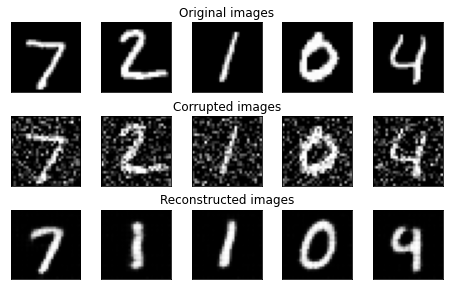

EPOCH 5/30
	 partial train loss (single batch): 0.082723
	 partial train loss (single batch): 0.081478
	 partial train loss (single batch): 0.083045
	 partial train loss (single batch): 0.083253
	 partial train loss (single batch): 0.083150
	 partial train loss (single batch): 0.082735
	 partial train loss (single batch): 0.086046
	 partial train loss (single batch): 0.081221
	 partial train loss (single batch): 0.085284
	 partial train loss (single batch): 0.081010
	 partial train loss (single batch): 0.085069
	 partial train loss (single batch): 0.079367
	 partial train loss (single batch): 0.086278
	 partial train loss (single batch): 0.079914
	 partial train loss (single batch): 0.082881
	 partial train loss (single batch): 0.082039
	 partial train loss (single batch): 0.083188
	 partial train loss (single batch): 0.084797
	 partial train loss (single batch): 0.085414
	 partial train loss (single batch): 0.080757
	 partial train loss (single batch): 0.079765
	 partial train loss (s

	 partial train loss (single batch): 0.079259
	 partial train loss (single batch): 0.076913
	 partial train loss (single batch): 0.080347
	 partial train loss (single batch): 0.081512
	 partial train loss (single batch): 0.082620
	 partial train loss (single batch): 0.073584
	 partial train loss (single batch): 0.080678
	 partial train loss (single batch): 0.078803

 EPOCH 5/30 	 train loss 0.082 	 val loss 0.081


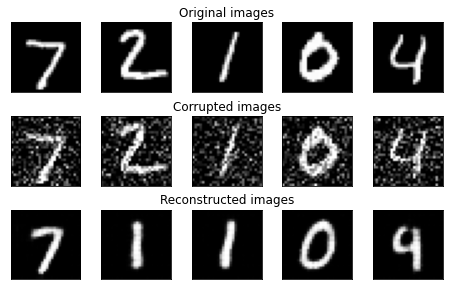

EPOCH 6/30
	 partial train loss (single batch): 0.081051
	 partial train loss (single batch): 0.079751
	 partial train loss (single batch): 0.081586
	 partial train loss (single batch): 0.081728
	 partial train loss (single batch): 0.082035
	 partial train loss (single batch): 0.081172
	 partial train loss (single batch): 0.084724
	 partial train loss (single batch): 0.079893
	 partial train loss (single batch): 0.083918
	 partial train loss (single batch): 0.079554
	 partial train loss (single batch): 0.083906
	 partial train loss (single batch): 0.077537
	 partial train loss (single batch): 0.084530
	 partial train loss (single batch): 0.078204
	 partial train loss (single batch): 0.081561
	 partial train loss (single batch): 0.080487
	 partial train loss (single batch): 0.081333
	 partial train loss (single batch): 0.082996
	 partial train loss (single batch): 0.083768
	 partial train loss (single batch): 0.079169
	 partial train loss (single batch): 0.077874
	 partial train loss (s

	 partial train loss (single batch): 0.084233
	 partial train loss (single batch): 0.078043
	 partial train loss (single batch): 0.076022
	 partial train loss (single batch): 0.079004
	 partial train loss (single batch): 0.079999
	 partial train loss (single batch): 0.081682
	 partial train loss (single batch): 0.072615
	 partial train loss (single batch): 0.079608
	 partial train loss (single batch): 0.077601

 EPOCH 6/30 	 train loss 0.080 	 val loss 0.080


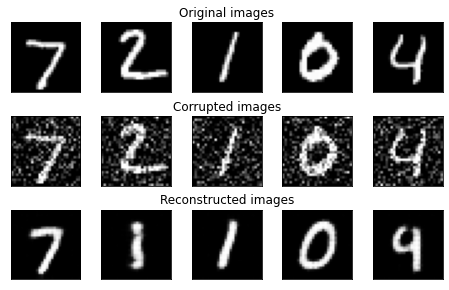

EPOCH 7/30
	 partial train loss (single batch): 0.079834
	 partial train loss (single batch): 0.079038
	 partial train loss (single batch): 0.080268
	 partial train loss (single batch): 0.080383
	 partial train loss (single batch): 0.080704
	 partial train loss (single batch): 0.080091
	 partial train loss (single batch): 0.083643
	 partial train loss (single batch): 0.078346
	 partial train loss (single batch): 0.082921
	 partial train loss (single batch): 0.078239
	 partial train loss (single batch): 0.082936
	 partial train loss (single batch): 0.077153
	 partial train loss (single batch): 0.083383
	 partial train loss (single batch): 0.077003
	 partial train loss (single batch): 0.080798
	 partial train loss (single batch): 0.079252
	 partial train loss (single batch): 0.080191
	 partial train loss (single batch): 0.082213
	 partial train loss (single batch): 0.083086
	 partial train loss (single batch): 0.078454
	 partial train loss (single batch): 0.076823
	 partial train loss (s

	 partial train loss (single batch): 0.082766
	 partial train loss (single batch): 0.077770
	 partial train loss (single batch): 0.075329
	 partial train loss (single batch): 0.078380
	 partial train loss (single batch): 0.079724
	 partial train loss (single batch): 0.081050
	 partial train loss (single batch): 0.071959
	 partial train loss (single batch): 0.079044
	 partial train loss (single batch): 0.076889

 EPOCH 7/30 	 train loss 0.079 	 val loss 0.080


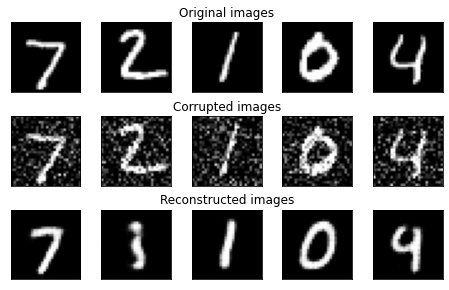

EPOCH 8/30
	 partial train loss (single batch): 0.079228
	 partial train loss (single batch): 0.078397
	 partial train loss (single batch): 0.079715
	 partial train loss (single batch): 0.079593
	 partial train loss (single batch): 0.079489
	 partial train loss (single batch): 0.079370
	 partial train loss (single batch): 0.082638
	 partial train loss (single batch): 0.077281
	 partial train loss (single batch): 0.082294
	 partial train loss (single batch): 0.077611
	 partial train loss (single batch): 0.081948
	 partial train loss (single batch): 0.076347
	 partial train loss (single batch): 0.082568
	 partial train loss (single batch): 0.076127
	 partial train loss (single batch): 0.079787
	 partial train loss (single batch): 0.078496
	 partial train loss (single batch): 0.079528
	 partial train loss (single batch): 0.081719
	 partial train loss (single batch): 0.082063
	 partial train loss (single batch): 0.077681
	 partial train loss (single batch): 0.076135
	 partial train loss (s

	 partial train loss (single batch): 0.081840
	 partial train loss (single batch): 0.077166
	 partial train loss (single batch): 0.075359
	 partial train loss (single batch): 0.078094
	 partial train loss (single batch): 0.079134
	 partial train loss (single batch): 0.080215
	 partial train loss (single batch): 0.071566
	 partial train loss (single batch): 0.078356
	 partial train loss (single batch): 0.075966

 EPOCH 8/30 	 train loss 0.079 	 val loss 0.079


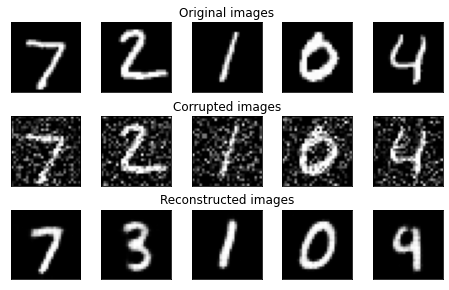

EPOCH 9/30
	 partial train loss (single batch): 0.078660
	 partial train loss (single batch): 0.077899
	 partial train loss (single batch): 0.079122
	 partial train loss (single batch): 0.078594
	 partial train loss (single batch): 0.078841
	 partial train loss (single batch): 0.078672
	 partial train loss (single batch): 0.081559
	 partial train loss (single batch): 0.076623
	 partial train loss (single batch): 0.082010
	 partial train loss (single batch): 0.076530
	 partial train loss (single batch): 0.081225
	 partial train loss (single batch): 0.076095
	 partial train loss (single batch): 0.081902
	 partial train loss (single batch): 0.075633
	 partial train loss (single batch): 0.079835
	 partial train loss (single batch): 0.077788
	 partial train loss (single batch): 0.079061
	 partial train loss (single batch): 0.080988
	 partial train loss (single batch): 0.081396
	 partial train loss (single batch): 0.077145
	 partial train loss (single batch): 0.075571
	 partial train loss (s

	 partial train loss (single batch): 0.081416
	 partial train loss (single batch): 0.081195
	 partial train loss (single batch): 0.076977
	 partial train loss (single batch): 0.074929
	 partial train loss (single batch): 0.077456
	 partial train loss (single batch): 0.078383
	 partial train loss (single batch): 0.079568
	 partial train loss (single batch): 0.071065
	 partial train loss (single batch): 0.077928
	 partial train loss (single batch): 0.075377

 EPOCH 9/30 	 train loss 0.078 	 val loss 0.079


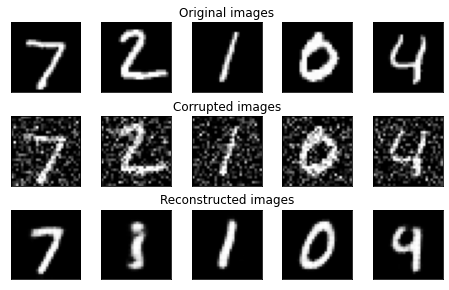

EPOCH 10/30
	 partial train loss (single batch): 0.077560
	 partial train loss (single batch): 0.077638
	 partial train loss (single batch): 0.078115
	 partial train loss (single batch): 0.078122
	 partial train loss (single batch): 0.077929
	 partial train loss (single batch): 0.077884
	 partial train loss (single batch): 0.081065
	 partial train loss (single batch): 0.075839
	 partial train loss (single batch): 0.080983
	 partial train loss (single batch): 0.075922
	 partial train loss (single batch): 0.080259
	 partial train loss (single batch): 0.075121
	 partial train loss (single batch): 0.081044
	 partial train loss (single batch): 0.074911
	 partial train loss (single batch): 0.078885
	 partial train loss (single batch): 0.077154
	 partial train loss (single batch): 0.078397
	 partial train loss (single batch): 0.080441
	 partial train loss (single batch): 0.080860
	 partial train loss (single batch): 0.076346
	 partial train loss (single batch): 0.074648
	 partial train loss (

	 partial train loss (single batch): 0.081092
	 partial train loss (single batch): 0.076115
	 partial train loss (single batch): 0.074516
	 partial train loss (single batch): 0.076934
	 partial train loss (single batch): 0.078019
	 partial train loss (single batch): 0.079136
	 partial train loss (single batch): 0.070681
	 partial train loss (single batch): 0.077233
	 partial train loss (single batch): 0.075245

 EPOCH 10/30 	 train loss 0.077 	 val loss 0.078


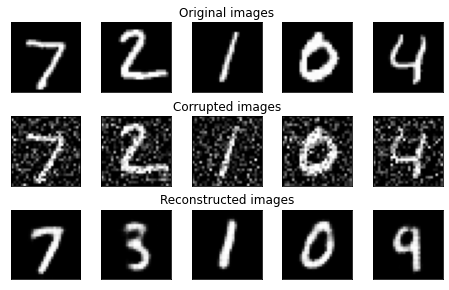

EPOCH 11/30
	 partial train loss (single batch): 0.076963
	 partial train loss (single batch): 0.076997
	 partial train loss (single batch): 0.077211
	 partial train loss (single batch): 0.077571
	 partial train loss (single batch): 0.077610
	 partial train loss (single batch): 0.077738
	 partial train loss (single batch): 0.081122
	 partial train loss (single batch): 0.075394
	 partial train loss (single batch): 0.080195
	 partial train loss (single batch): 0.075337
	 partial train loss (single batch): 0.080329
	 partial train loss (single batch): 0.074929
	 partial train loss (single batch): 0.080502
	 partial train loss (single batch): 0.074672
	 partial train loss (single batch): 0.078737
	 partial train loss (single batch): 0.076346
	 partial train loss (single batch): 0.077633
	 partial train loss (single batch): 0.079775
	 partial train loss (single batch): 0.080363
	 partial train loss (single batch): 0.075782
	 partial train loss (single batch): 0.074367
	 partial train loss (

	 partial train loss (single batch): 0.080512
	 partial train loss (single batch): 0.080735
	 partial train loss (single batch): 0.075943
	 partial train loss (single batch): 0.074030
	 partial train loss (single batch): 0.076707
	 partial train loss (single batch): 0.077364
	 partial train loss (single batch): 0.078729
	 partial train loss (single batch): 0.070309
	 partial train loss (single batch): 0.076855
	 partial train loss (single batch): 0.074725

 EPOCH 11/30 	 train loss 0.077 	 val loss 0.078


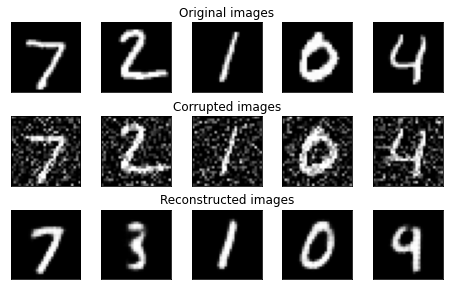

EPOCH 12/30
	 partial train loss (single batch): 0.076456
	 partial train loss (single batch): 0.076464
	 partial train loss (single batch): 0.076608
	 partial train loss (single batch): 0.077083
	 partial train loss (single batch): 0.077197
	 partial train loss (single batch): 0.077223
	 partial train loss (single batch): 0.080435
	 partial train loss (single batch): 0.075168
	 partial train loss (single batch): 0.079269
	 partial train loss (single batch): 0.074941
	 partial train loss (single batch): 0.079492
	 partial train loss (single batch): 0.074351
	 partial train loss (single batch): 0.079929
	 partial train loss (single batch): 0.073999
	 partial train loss (single batch): 0.078259
	 partial train loss (single batch): 0.075902
	 partial train loss (single batch): 0.077216
	 partial train loss (single batch): 0.079509
	 partial train loss (single batch): 0.080134
	 partial train loss (single batch): 0.075116
	 partial train loss (single batch): 0.073392
	 partial train loss (

	 partial train loss (single batch): 0.080217
	 partial train loss (single batch): 0.080131
	 partial train loss (single batch): 0.075255
	 partial train loss (single batch): 0.073592
	 partial train loss (single batch): 0.076171
	 partial train loss (single batch): 0.077155
	 partial train loss (single batch): 0.078343
	 partial train loss (single batch): 0.070007
	 partial train loss (single batch): 0.076537
	 partial train loss (single batch): 0.074352

 EPOCH 12/30 	 train loss 0.077 	 val loss 0.077


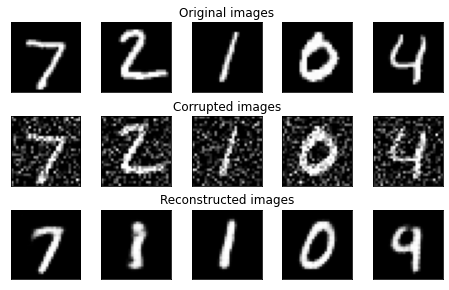

EPOCH 13/30
	 partial train loss (single batch): 0.075964
	 partial train loss (single batch): 0.076084
	 partial train loss (single batch): 0.076497
	 partial train loss (single batch): 0.076402
	 partial train loss (single batch): 0.076723
	 partial train loss (single batch): 0.076580
	 partial train loss (single batch): 0.080041
	 partial train loss (single batch): 0.074837
	 partial train loss (single batch): 0.079157
	 partial train loss (single batch): 0.074392
	 partial train loss (single batch): 0.079038
	 partial train loss (single batch): 0.073824
	 partial train loss (single batch): 0.079530
	 partial train loss (single batch): 0.073680
	 partial train loss (single batch): 0.077877
	 partial train loss (single batch): 0.075646
	 partial train loss (single batch): 0.077015
	 partial train loss (single batch): 0.079227
	 partial train loss (single batch): 0.079351
	 partial train loss (single batch): 0.074928
	 partial train loss (single batch): 0.073022
	 partial train loss (

	 partial train loss (single batch): 0.074763
	 partial train loss (single batch): 0.073200
	 partial train loss (single batch): 0.075878
	 partial train loss (single batch): 0.076582
	 partial train loss (single batch): 0.078663
	 partial train loss (single batch): 0.069792
	 partial train loss (single batch): 0.076256
	 partial train loss (single batch): 0.073515

 EPOCH 13/30 	 train loss 0.076 	 val loss 0.077


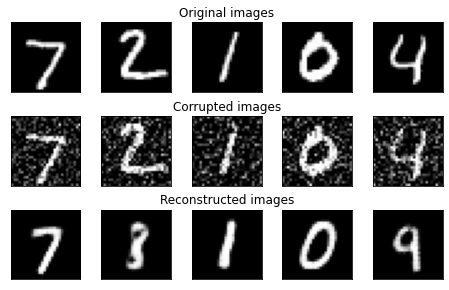

EPOCH 14/30
	 partial train loss (single batch): 0.075325
	 partial train loss (single batch): 0.075575
	 partial train loss (single batch): 0.076183
	 partial train loss (single batch): 0.076227
	 partial train loss (single batch): 0.076409
	 partial train loss (single batch): 0.076297
	 partial train loss (single batch): 0.080035
	 partial train loss (single batch): 0.074070
	 partial train loss (single batch): 0.078559
	 partial train loss (single batch): 0.074030
	 partial train loss (single batch): 0.079110
	 partial train loss (single batch): 0.073555
	 partial train loss (single batch): 0.079323
	 partial train loss (single batch): 0.073455
	 partial train loss (single batch): 0.077285
	 partial train loss (single batch): 0.075222
	 partial train loss (single batch): 0.076565
	 partial train loss (single batch): 0.079031
	 partial train loss (single batch): 0.079237
	 partial train loss (single batch): 0.074691
	 partial train loss (single batch): 0.072500
	 partial train loss (

	 partial train loss (single batch): 0.074238
	 partial train loss (single batch): 0.072754
	 partial train loss (single batch): 0.075860
	 partial train loss (single batch): 0.076272
	 partial train loss (single batch): 0.078286
	 partial train loss (single batch): 0.069172
	 partial train loss (single batch): 0.075467
	 partial train loss (single batch): 0.073696

 EPOCH 14/30 	 train loss 0.076 	 val loss 0.077


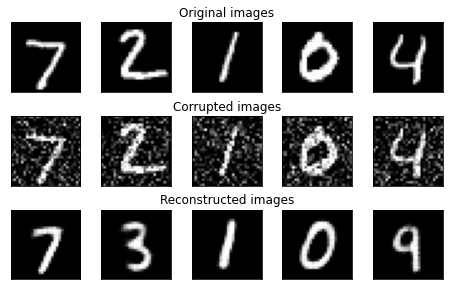

EPOCH 15/30
	 partial train loss (single batch): 0.075181
	 partial train loss (single batch): 0.075152
	 partial train loss (single batch): 0.075580
	 partial train loss (single batch): 0.075543
	 partial train loss (single batch): 0.075753
	 partial train loss (single batch): 0.075457
	 partial train loss (single batch): 0.079576
	 partial train loss (single batch): 0.074135
	 partial train loss (single batch): 0.078675
	 partial train loss (single batch): 0.073369
	 partial train loss (single batch): 0.078106
	 partial train loss (single batch): 0.073197
	 partial train loss (single batch): 0.079172
	 partial train loss (single batch): 0.073326
	 partial train loss (single batch): 0.076995
	 partial train loss (single batch): 0.074901
	 partial train loss (single batch): 0.076519
	 partial train loss (single batch): 0.078790
	 partial train loss (single batch): 0.078700
	 partial train loss (single batch): 0.074341
	 partial train loss (single batch): 0.072052
	 partial train loss (

	 partial train loss (single batch): 0.079792
	 partial train loss (single batch): 0.074244
	 partial train loss (single batch): 0.072374
	 partial train loss (single batch): 0.075428
	 partial train loss (single batch): 0.075976
	 partial train loss (single batch): 0.077444
	 partial train loss (single batch): 0.069359
	 partial train loss (single batch): 0.075331
	 partial train loss (single batch): 0.073080

 EPOCH 15/30 	 train loss 0.075 	 val loss 0.076


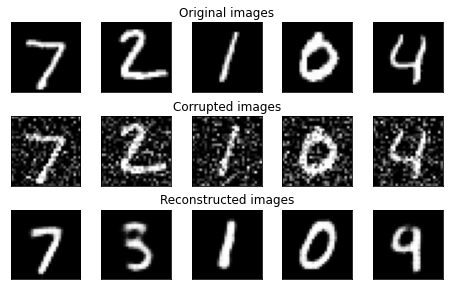

EPOCH 16/30
	 partial train loss (single batch): 0.074840
	 partial train loss (single batch): 0.075379
	 partial train loss (single batch): 0.075264
	 partial train loss (single batch): 0.075566
	 partial train loss (single batch): 0.075454
	 partial train loss (single batch): 0.075557
	 partial train loss (single batch): 0.078962
	 partial train loss (single batch): 0.073785
	 partial train loss (single batch): 0.078101
	 partial train loss (single batch): 0.073362
	 partial train loss (single batch): 0.077701
	 partial train loss (single batch): 0.073057
	 partial train loss (single batch): 0.078971
	 partial train loss (single batch): 0.072955
	 partial train loss (single batch): 0.076980
	 partial train loss (single batch): 0.074423
	 partial train loss (single batch): 0.076100
	 partial train loss (single batch): 0.078573
	 partial train loss (single batch): 0.078505
	 partial train loss (single batch): 0.074488
	 partial train loss (single batch): 0.071916
	 partial train loss (

	 partial train loss (single batch): 0.079676
	 partial train loss (single batch): 0.073967
	 partial train loss (single batch): 0.072956
	 partial train loss (single batch): 0.075739
	 partial train loss (single batch): 0.075651
	 partial train loss (single batch): 0.077794
	 partial train loss (single batch): 0.069320
	 partial train loss (single batch): 0.075612
	 partial train loss (single batch): 0.072656

 EPOCH 16/30 	 train loss 0.075 	 val loss 0.076


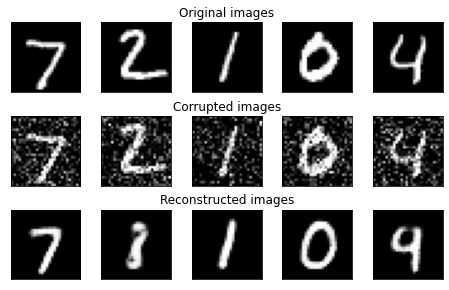

EPOCH 17/30
	 partial train loss (single batch): 0.074828
	 partial train loss (single batch): 0.074709
	 partial train loss (single batch): 0.075828
	 partial train loss (single batch): 0.075954
	 partial train loss (single batch): 0.075442
	 partial train loss (single batch): 0.075669
	 partial train loss (single batch): 0.079013
	 partial train loss (single batch): 0.073303
	 partial train loss (single batch): 0.077772
	 partial train loss (single batch): 0.072770
	 partial train loss (single batch): 0.077886
	 partial train loss (single batch): 0.072949
	 partial train loss (single batch): 0.079004
	 partial train loss (single batch): 0.072889
	 partial train loss (single batch): 0.076703
	 partial train loss (single batch): 0.074545
	 partial train loss (single batch): 0.076135
	 partial train loss (single batch): 0.078481
	 partial train loss (single batch): 0.078095
	 partial train loss (single batch): 0.074159
	 partial train loss (single batch): 0.071751
	 partial train loss (

	 partial train loss (single batch): 0.079446
	 partial train loss (single batch): 0.074058
	 partial train loss (single batch): 0.072142
	 partial train loss (single batch): 0.075258
	 partial train loss (single batch): 0.075340
	 partial train loss (single batch): 0.077589
	 partial train loss (single batch): 0.069426
	 partial train loss (single batch): 0.075498
	 partial train loss (single batch): 0.072785

 EPOCH 17/30 	 train loss 0.075 	 val loss 0.076


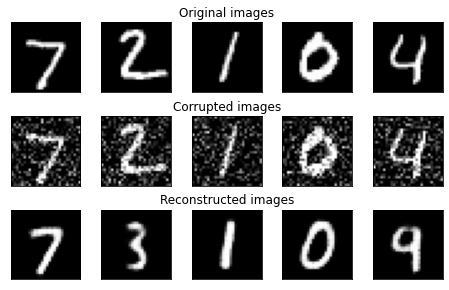

EPOCH 18/30
	 partial train loss (single batch): 0.074402
	 partial train loss (single batch): 0.074208
	 partial train loss (single batch): 0.075116
	 partial train loss (single batch): 0.075448
	 partial train loss (single batch): 0.074880
	 partial train loss (single batch): 0.075435
	 partial train loss (single batch): 0.078747
	 partial train loss (single batch): 0.073378
	 partial train loss (single batch): 0.077203
	 partial train loss (single batch): 0.072515
	 partial train loss (single batch): 0.077232
	 partial train loss (single batch): 0.072633
	 partial train loss (single batch): 0.078556
	 partial train loss (single batch): 0.072666
	 partial train loss (single batch): 0.076536
	 partial train loss (single batch): 0.074313
	 partial train loss (single batch): 0.075639
	 partial train loss (single batch): 0.078432
	 partial train loss (single batch): 0.077819
	 partial train loss (single batch): 0.073811
	 partial train loss (single batch): 0.071411
	 partial train loss (

	 partial train loss (single batch): 0.078790
	 partial train loss (single batch): 0.079581
	 partial train loss (single batch): 0.073748
	 partial train loss (single batch): 0.071904
	 partial train loss (single batch): 0.074690
	 partial train loss (single batch): 0.075382
	 partial train loss (single batch): 0.077221
	 partial train loss (single batch): 0.068596
	 partial train loss (single batch): 0.074955
	 partial train loss (single batch): 0.071748

 EPOCH 18/30 	 train loss 0.075 	 val loss 0.076


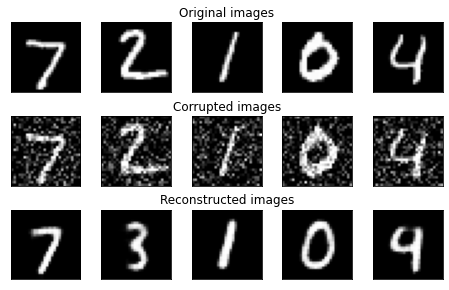

EPOCH 19/30
	 partial train loss (single batch): 0.074377
	 partial train loss (single batch): 0.073862
	 partial train loss (single batch): 0.074819
	 partial train loss (single batch): 0.075183
	 partial train loss (single batch): 0.074584
	 partial train loss (single batch): 0.074756
	 partial train loss (single batch): 0.078303
	 partial train loss (single batch): 0.072502
	 partial train loss (single batch): 0.076856
	 partial train loss (single batch): 0.072347
	 partial train loss (single batch): 0.076824
	 partial train loss (single batch): 0.073002
	 partial train loss (single batch): 0.078216
	 partial train loss (single batch): 0.072323
	 partial train loss (single batch): 0.076033
	 partial train loss (single batch): 0.074588
	 partial train loss (single batch): 0.075037
	 partial train loss (single batch): 0.078339
	 partial train loss (single batch): 0.077676
	 partial train loss (single batch): 0.073687
	 partial train loss (single batch): 0.071400
	 partial train loss (

	 partial train loss (single batch): 0.078242
	 partial train loss (single batch): 0.079250
	 partial train loss (single batch): 0.073187
	 partial train loss (single batch): 0.071310
	 partial train loss (single batch): 0.075183
	 partial train loss (single batch): 0.074780
	 partial train loss (single batch): 0.076895
	 partial train loss (single batch): 0.068397
	 partial train loss (single batch): 0.074573
	 partial train loss (single batch): 0.072145

 EPOCH 19/30 	 train loss 0.074 	 val loss 0.076


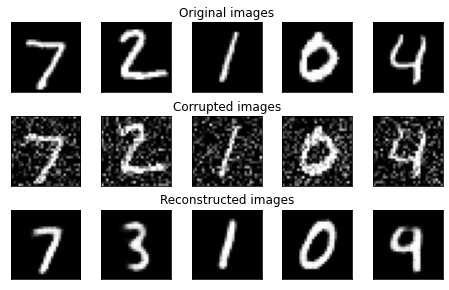

EPOCH 20/30
	 partial train loss (single batch): 0.074173
	 partial train loss (single batch): 0.074331
	 partial train loss (single batch): 0.074826
	 partial train loss (single batch): 0.074724
	 partial train loss (single batch): 0.074774
	 partial train loss (single batch): 0.074897
	 partial train loss (single batch): 0.078016
	 partial train loss (single batch): 0.072533
	 partial train loss (single batch): 0.076934
	 partial train loss (single batch): 0.072575
	 partial train loss (single batch): 0.076313
	 partial train loss (single batch): 0.072380
	 partial train loss (single batch): 0.078181
	 partial train loss (single batch): 0.071769
	 partial train loss (single batch): 0.075541
	 partial train loss (single batch): 0.073991
	 partial train loss (single batch): 0.075434
	 partial train loss (single batch): 0.077922
	 partial train loss (single batch): 0.077525
	 partial train loss (single batch): 0.073702
	 partial train loss (single batch): 0.070952
	 partial train loss (

	 partial train loss (single batch): 0.073104
	 partial train loss (single batch): 0.071482
	 partial train loss (single batch): 0.074785
	 partial train loss (single batch): 0.074706
	 partial train loss (single batch): 0.076634
	 partial train loss (single batch): 0.068413
	 partial train loss (single batch): 0.074709
	 partial train loss (single batch): 0.072041

 EPOCH 20/30 	 train loss 0.074 	 val loss 0.075


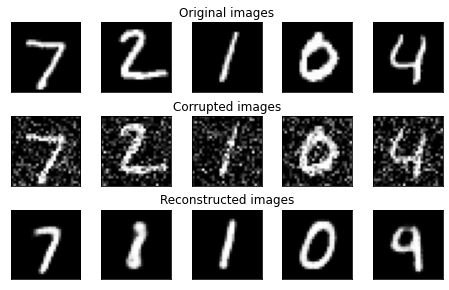

EPOCH 21/30
	 partial train loss (single batch): 0.073924
	 partial train loss (single batch): 0.073164
	 partial train loss (single batch): 0.074161
	 partial train loss (single batch): 0.074256
	 partial train loss (single batch): 0.074323
	 partial train loss (single batch): 0.074559
	 partial train loss (single batch): 0.077748
	 partial train loss (single batch): 0.072100
	 partial train loss (single batch): 0.076430
	 partial train loss (single batch): 0.071592
	 partial train loss (single batch): 0.075986
	 partial train loss (single batch): 0.072690
	 partial train loss (single batch): 0.077675
	 partial train loss (single batch): 0.071869
	 partial train loss (single batch): 0.075296
	 partial train loss (single batch): 0.073648
	 partial train loss (single batch): 0.075017
	 partial train loss (single batch): 0.077582
	 partial train loss (single batch): 0.077104
	 partial train loss (single batch): 0.073022
	 partial train loss (single batch): 0.070813
	 partial train loss (

	 partial train loss (single batch): 0.073579
	 partial train loss (single batch): 0.071255
	 partial train loss (single batch): 0.074741
	 partial train loss (single batch): 0.074378
	 partial train loss (single batch): 0.076623
	 partial train loss (single batch): 0.068623
	 partial train loss (single batch): 0.074601
	 partial train loss (single batch): 0.072101

 EPOCH 21/30 	 train loss 0.074 	 val loss 0.075


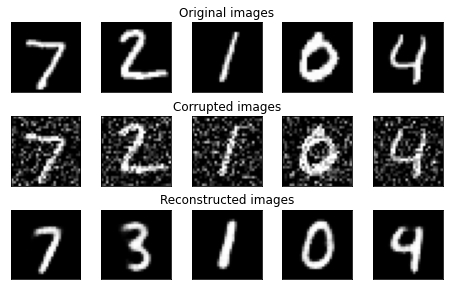

EPOCH 22/30
	 partial train loss (single batch): 0.073655
	 partial train loss (single batch): 0.073298
	 partial train loss (single batch): 0.073877
	 partial train loss (single batch): 0.074328
	 partial train loss (single batch): 0.074239
	 partial train loss (single batch): 0.074376
	 partial train loss (single batch): 0.077646
	 partial train loss (single batch): 0.072432
	 partial train loss (single batch): 0.076231
	 partial train loss (single batch): 0.071779
	 partial train loss (single batch): 0.075843
	 partial train loss (single batch): 0.072963
	 partial train loss (single batch): 0.077757
	 partial train loss (single batch): 0.071743
	 partial train loss (single batch): 0.075443
	 partial train loss (single batch): 0.073717
	 partial train loss (single batch): 0.075198
	 partial train loss (single batch): 0.077190
	 partial train loss (single batch): 0.076951
	 partial train loss (single batch): 0.073166
	 partial train loss (single batch): 0.070714
	 partial train loss (

	 partial train loss (single batch): 0.078757
	 partial train loss (single batch): 0.072744
	 partial train loss (single batch): 0.070717
	 partial train loss (single batch): 0.074059
	 partial train loss (single batch): 0.074306
	 partial train loss (single batch): 0.076301
	 partial train loss (single batch): 0.068156
	 partial train loss (single batch): 0.073958
	 partial train loss (single batch): 0.071705

 EPOCH 22/30 	 train loss 0.074 	 val loss 0.075


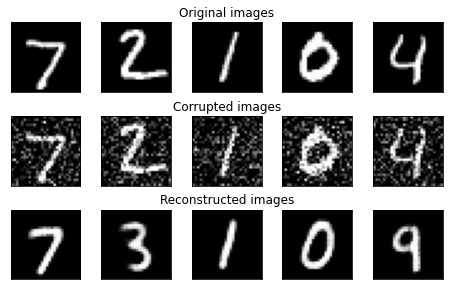

EPOCH 23/30
	 partial train loss (single batch): 0.073359
	 partial train loss (single batch): 0.072966
	 partial train loss (single batch): 0.073958
	 partial train loss (single batch): 0.074020
	 partial train loss (single batch): 0.074298
	 partial train loss (single batch): 0.074237
	 partial train loss (single batch): 0.077374
	 partial train loss (single batch): 0.071435
	 partial train loss (single batch): 0.076204
	 partial train loss (single batch): 0.071532
	 partial train loss (single batch): 0.075985
	 partial train loss (single batch): 0.071980
	 partial train loss (single batch): 0.077547
	 partial train loss (single batch): 0.071472
	 partial train loss (single batch): 0.075167
	 partial train loss (single batch): 0.073400
	 partial train loss (single batch): 0.075031
	 partial train loss (single batch): 0.077193
	 partial train loss (single batch): 0.076642
	 partial train loss (single batch): 0.072905
	 partial train loss (single batch): 0.070084
	 partial train loss (

	 partial train loss (single batch): 0.072560
	 partial train loss (single batch): 0.070531
	 partial train loss (single batch): 0.073893
	 partial train loss (single batch): 0.073923
	 partial train loss (single batch): 0.076047
	 partial train loss (single batch): 0.067658
	 partial train loss (single batch): 0.073742
	 partial train loss (single batch): 0.071228

 EPOCH 23/30 	 train loss 0.074 	 val loss 0.075


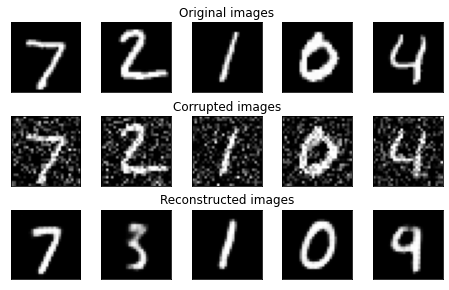

EPOCH 24/30
	 partial train loss (single batch): 0.073414
	 partial train loss (single batch): 0.072467
	 partial train loss (single batch): 0.073601
	 partial train loss (single batch): 0.073872
	 partial train loss (single batch): 0.073884
	 partial train loss (single batch): 0.073997
	 partial train loss (single batch): 0.077035
	 partial train loss (single batch): 0.071643
	 partial train loss (single batch): 0.075678
	 partial train loss (single batch): 0.071484
	 partial train loss (single batch): 0.075618
	 partial train loss (single batch): 0.071969
	 partial train loss (single batch): 0.077251
	 partial train loss (single batch): 0.071093
	 partial train loss (single batch): 0.074819
	 partial train loss (single batch): 0.073201
	 partial train loss (single batch): 0.074928
	 partial train loss (single batch): 0.076670
	 partial train loss (single batch): 0.076647
	 partial train loss (single batch): 0.072828
	 partial train loss (single batch): 0.069963
	 partial train loss (

	 partial train loss (single batch): 0.077877
	 partial train loss (single batch): 0.078539
	 partial train loss (single batch): 0.072381
	 partial train loss (single batch): 0.070485
	 partial train loss (single batch): 0.074271
	 partial train loss (single batch): 0.073908
	 partial train loss (single batch): 0.075883
	 partial train loss (single batch): 0.067616
	 partial train loss (single batch): 0.073816
	 partial train loss (single batch): 0.071501

 EPOCH 24/30 	 train loss 0.074 	 val loss 0.075


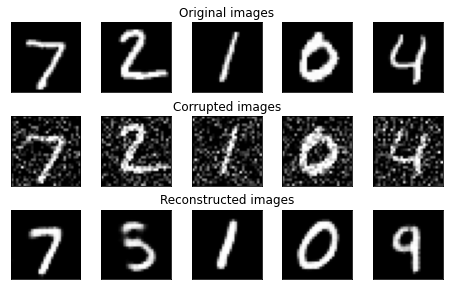

EPOCH 25/30
	 partial train loss (single batch): 0.073696
	 partial train loss (single batch): 0.072776
	 partial train loss (single batch): 0.074175
	 partial train loss (single batch): 0.074269
	 partial train loss (single batch): 0.073531
	 partial train loss (single batch): 0.074088
	 partial train loss (single batch): 0.076897
	 partial train loss (single batch): 0.071557
	 partial train loss (single batch): 0.075617
	 partial train loss (single batch): 0.071366
	 partial train loss (single batch): 0.075476
	 partial train loss (single batch): 0.072440
	 partial train loss (single batch): 0.077613
	 partial train loss (single batch): 0.071265
	 partial train loss (single batch): 0.074755
	 partial train loss (single batch): 0.073186
	 partial train loss (single batch): 0.075034
	 partial train loss (single batch): 0.076383
	 partial train loss (single batch): 0.076694
	 partial train loss (single batch): 0.073031
	 partial train loss (single batch): 0.069869
	 partial train loss (

	 partial train loss (single batch): 0.078225
	 partial train loss (single batch): 0.072138
	 partial train loss (single batch): 0.070227
	 partial train loss (single batch): 0.074431
	 partial train loss (single batch): 0.074009
	 partial train loss (single batch): 0.075867
	 partial train loss (single batch): 0.067340
	 partial train loss (single batch): 0.073837
	 partial train loss (single batch): 0.071330

 EPOCH 25/30 	 train loss 0.074 	 val loss 0.075


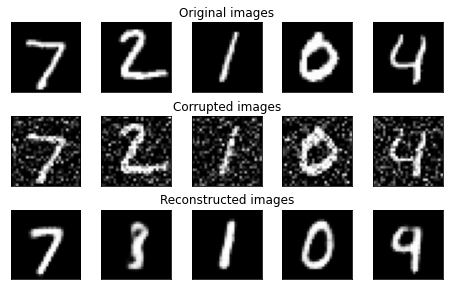

EPOCH 26/30
	 partial train loss (single batch): 0.073433
	 partial train loss (single batch): 0.072778
	 partial train loss (single batch): 0.073331
	 partial train loss (single batch): 0.073930
	 partial train loss (single batch): 0.073426
	 partial train loss (single batch): 0.073555
	 partial train loss (single batch): 0.076615
	 partial train loss (single batch): 0.071082
	 partial train loss (single batch): 0.075292
	 partial train loss (single batch): 0.071308
	 partial train loss (single batch): 0.075160
	 partial train loss (single batch): 0.071743
	 partial train loss (single batch): 0.077337
	 partial train loss (single batch): 0.071207
	 partial train loss (single batch): 0.074758
	 partial train loss (single batch): 0.073275
	 partial train loss (single batch): 0.074858
	 partial train loss (single batch): 0.076379
	 partial train loss (single batch): 0.076623
	 partial train loss (single batch): 0.072700
	 partial train loss (single batch): 0.069949
	 partial train loss (

	 partial train loss (single batch): 0.072552
	 partial train loss (single batch): 0.070592
	 partial train loss (single batch): 0.074162
	 partial train loss (single batch): 0.074074
	 partial train loss (single batch): 0.075862
	 partial train loss (single batch): 0.067975
	 partial train loss (single batch): 0.073807
	 partial train loss (single batch): 0.071578

 EPOCH 26/30 	 train loss 0.073 	 val loss 0.075


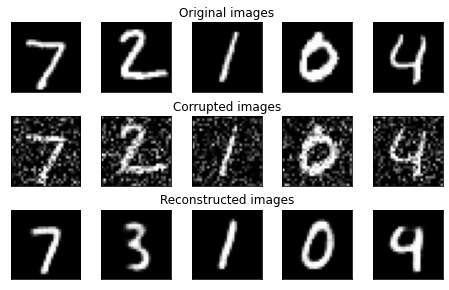

EPOCH 27/30
	 partial train loss (single batch): 0.073199
	 partial train loss (single batch): 0.072323
	 partial train loss (single batch): 0.073608
	 partial train loss (single batch): 0.073669
	 partial train loss (single batch): 0.073480
	 partial train loss (single batch): 0.073652
	 partial train loss (single batch): 0.076688
	 partial train loss (single batch): 0.071693
	 partial train loss (single batch): 0.075649
	 partial train loss (single batch): 0.071322
	 partial train loss (single batch): 0.075152
	 partial train loss (single batch): 0.072014
	 partial train loss (single batch): 0.077009
	 partial train loss (single batch): 0.070948
	 partial train loss (single batch): 0.074994
	 partial train loss (single batch): 0.072871
	 partial train loss (single batch): 0.074490
	 partial train loss (single batch): 0.076528
	 partial train loss (single batch): 0.076280
	 partial train loss (single batch): 0.072374
	 partial train loss (single batch): 0.069804
	 partial train loss (

	 partial train loss (single batch): 0.071871
	 partial train loss (single batch): 0.070636
	 partial train loss (single batch): 0.074107
	 partial train loss (single batch): 0.073802
	 partial train loss (single batch): 0.075702
	 partial train loss (single batch): 0.066985
	 partial train loss (single batch): 0.074061
	 partial train loss (single batch): 0.071140

 EPOCH 27/30 	 train loss 0.073 	 val loss 0.075


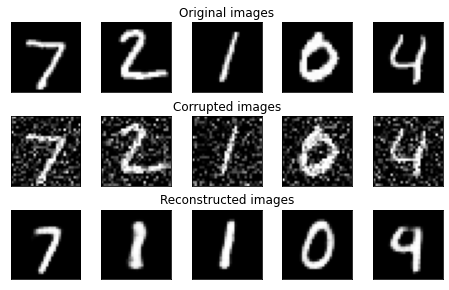

EPOCH 28/30
	 partial train loss (single batch): 0.072881
	 partial train loss (single batch): 0.072132
	 partial train loss (single batch): 0.073252
	 partial train loss (single batch): 0.073406
	 partial train loss (single batch): 0.073597
	 partial train loss (single batch): 0.073353
	 partial train loss (single batch): 0.076113
	 partial train loss (single batch): 0.070872
	 partial train loss (single batch): 0.075090
	 partial train loss (single batch): 0.070790
	 partial train loss (single batch): 0.074951
	 partial train loss (single batch): 0.071740
	 partial train loss (single batch): 0.076488
	 partial train loss (single batch): 0.070458
	 partial train loss (single batch): 0.074380
	 partial train loss (single batch): 0.073175
	 partial train loss (single batch): 0.074613
	 partial train loss (single batch): 0.076170
	 partial train loss (single batch): 0.076496
	 partial train loss (single batch): 0.072130
	 partial train loss (single batch): 0.069744
	 partial train loss (

	 partial train loss (single batch): 0.071590
	 partial train loss (single batch): 0.070446
	 partial train loss (single batch): 0.073843
	 partial train loss (single batch): 0.073897
	 partial train loss (single batch): 0.075613
	 partial train loss (single batch): 0.067237
	 partial train loss (single batch): 0.073272
	 partial train loss (single batch): 0.070543

 EPOCH 28/30 	 train loss 0.073 	 val loss 0.075


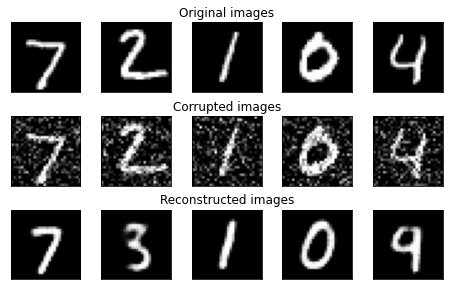

EPOCH 29/30
	 partial train loss (single batch): 0.073183
	 partial train loss (single batch): 0.072316
	 partial train loss (single batch): 0.072756
	 partial train loss (single batch): 0.073201
	 partial train loss (single batch): 0.073150
	 partial train loss (single batch): 0.073639
	 partial train loss (single batch): 0.076797
	 partial train loss (single batch): 0.071186
	 partial train loss (single batch): 0.074871
	 partial train loss (single batch): 0.070644
	 partial train loss (single batch): 0.074827
	 partial train loss (single batch): 0.071703
	 partial train loss (single batch): 0.076748
	 partial train loss (single batch): 0.070708
	 partial train loss (single batch): 0.074158
	 partial train loss (single batch): 0.072891
	 partial train loss (single batch): 0.074718
	 partial train loss (single batch): 0.075732
	 partial train loss (single batch): 0.076173
	 partial train loss (single batch): 0.072298
	 partial train loss (single batch): 0.069568
	 partial train loss (

	 partial train loss (single batch): 0.076684
	 partial train loss (single batch): 0.078209
	 partial train loss (single batch): 0.071453
	 partial train loss (single batch): 0.069956
	 partial train loss (single batch): 0.073246
	 partial train loss (single batch): 0.073446
	 partial train loss (single batch): 0.075440
	 partial train loss (single batch): 0.067316
	 partial train loss (single batch): 0.073328
	 partial train loss (single batch): 0.070719

 EPOCH 29/30 	 train loss 0.073 	 val loss 0.074


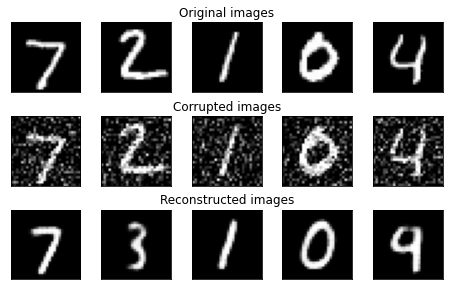

EPOCH 30/30
	 partial train loss (single batch): 0.072669
	 partial train loss (single batch): 0.071828
	 partial train loss (single batch): 0.072841
	 partial train loss (single batch): 0.073046
	 partial train loss (single batch): 0.072913
	 partial train loss (single batch): 0.073261
	 partial train loss (single batch): 0.075998
	 partial train loss (single batch): 0.070876
	 partial train loss (single batch): 0.074585
	 partial train loss (single batch): 0.070729
	 partial train loss (single batch): 0.074502
	 partial train loss (single batch): 0.071116
	 partial train loss (single batch): 0.076282
	 partial train loss (single batch): 0.070763
	 partial train loss (single batch): 0.074053
	 partial train loss (single batch): 0.072807
	 partial train loss (single batch): 0.074968
	 partial train loss (single batch): 0.075712
	 partial train loss (single batch): 0.076001
	 partial train loss (single batch): 0.072053
	 partial train loss (single batch): 0.069535
	 partial train loss (

	 partial train loss (single batch): 0.076616
	 partial train loss (single batch): 0.077711
	 partial train loss (single batch): 0.071327
	 partial train loss (single batch): 0.069406
	 partial train loss (single batch): 0.073505
	 partial train loss (single batch): 0.073427
	 partial train loss (single batch): 0.074967
	 partial train loss (single batch): 0.066821
	 partial train loss (single batch): 0.073344
	 partial train loss (single batch): 0.070321

 EPOCH 30/30 	 train loss 0.073 	 val loss 0.075


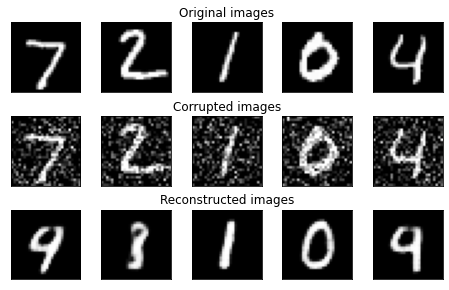

In [74]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

In [75]:
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()

0.07422441244125366

# Step 4: Generate new samples

In [76]:
# d =2 
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

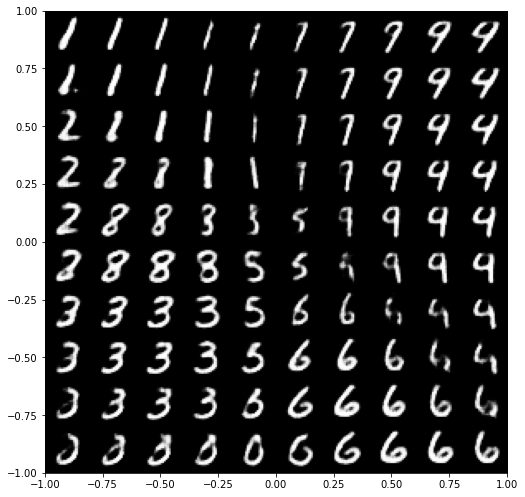

In [77]:
plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

# Step 5: Visualize latent code

In [78]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1845.25it/s]


In [79]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  label
0            3.579744         1.308199      7
1           -0.537950         0.397190      2
2           -0.459839         0.967775      1
3           -0.153475        -1.747078      0
4            1.316215        -0.023746      4
...               ...              ...    ...
9995        -1.829905         0.182904      2
9996        -0.260609        -0.505170      3
9997         0.715185         0.841179      4
9998         0.104808         0.088826      5
9999         0.350770        -0.853676      6

[10000 rows x 3 columns]

In [80]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [81]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [82]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

In [90]:
num_clusters=10

In [91]:
encoded_sample=encoded_samples.drop(['label'],axis=1)
k_mean_sample=torch.tensor(encoded_sample.values)
cluster_ids_x, cluster_centers = kmeans(
    X=k_mean_sample, num_clusters=num_clusters, distance='euclidean')

running k-means on cpu..


[running kmeans]: 42it [00:00, 194.35it/s, center_shift=0.000034, iteration=42, tol=0.000100]


In [93]:
encoded_samples['label'].shape

(10000,)

In [94]:
confusion_matrix(encoded_samples['label'], cluster_ids_x.numpy())

array([[  0,   0,   1,   1, 220, 177,   1,  12, 566,   2],
       [  0,   0,   0, 173,   1,   0,   0, 453,   0, 508],
       [  8, 373,   3,  12,   2,   0,   1,  98,  14, 521],
       [ 13,   2,   1,   0,   4,   0,   0, 980,   0,  10],
       [783,   1,   2,  70,  92,   0,   0,  25,   2,   7],
       [  9,   0,   2,  22,  40,   0,   0, 765,  25,  29],
       [  2,   0,   1,   1, 753,   2,   0, 165,  32,   2],
       [347,   5, 418,  26,   1,   0, 175,  23,   0,  33],
       [ 23,   1,   1,   9,  14,   0,   0, 861,  15,  50],
       [873,   0,  18,   7,  60,   0,   1,  43,   3,   4]], dtype=int64)

In [95]:
accuracy_score(encoded_samples['label'], cluster_ids_x.numpy())

0.0137

In [104]:
type(encoded_samples.iloc[1:100,0:256])

pandas.core.frame.DataFrame